In [1]:
import time
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy import stats

In [2]:
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re


In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier

from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler


In [63]:
# read in csv
posts = pd.read_csv('./datasets/ethbtc_posts.csv')

In [65]:
posts.head()

,selftext,title,subreddit
0,TPDNM,Is it possible for an invalid tx to stay in th...,ethereum
1,\nhttps://www.coindesk.com/16-ethereum-predict...,16 Ethereum Predictions From a Crypto Oracle,ethereum
2,TPDNM,What do you think is the max value of Eth befo...,ethereum
3,TPDNM,MYID Coins are currently an ethereum erc20,ethereum
4,TPDNM,90% of Ethereum Addresses are In Profit Follow...,ethereum


In [66]:
# check for null values 
posts.isnull().sum()

selftext     0
title        0
subreddit    0
dtype: int64

In [67]:
# get rid of TPDNM. 
# After doing a couple rounds of EDA and modelling, 
# I needed to reduce the amount of data
# for memory purposes
# and decided that removing the TPDNM  suffices
posts = posts[posts.selftext != 'TPDNM']
posts.reset_index(inplace=True)

In [68]:
#posts.set_index('index', inplace=True)

In [69]:
posts.head(10)

,index,selftext,title,subreddit
0,1,\nhttps://www.coindesk.com/16-ethereum-predict...,16 Ethereum Predictions From a Crypto Oracle,ethereum
1,8,Alright so I’ve been on the ETH train for some...,Upside of Ether?,ethereum
2,15,i tried almost a year and a half ago to get in...,i need help,ethereum
3,16,"Hi guys, I am not very familiar with ethereum ...",New to this... is now a good time to invest in...,ethereum
4,21,"Hi everyone, I think this is the most suited s...",Should I stake?,ethereum
5,23,Spoiler alert.. a lot. \nWe go frontrun on tr...,We took a tour around the dark forest to see h...,ethereum
6,24,So The Secret Network Ethereum bridge is live....,More secretEther users needed! Privacy fans un...,ethereum
7,29,Hi ethereum holders/investors/stakers etc.\n\n...,Max supply of ETH,ethereum
8,33,\nIf you’ve been keeping up with Ripple then y...,XRP right now lol,ethereum
9,35,I know the basics of crypto but I’m not the mo...,Is this a bubble?,ethereum


 - It's unclear to me if combining the 'selftext' and 'title' features into one 'text' column will introduce bias into my model because in my opinion language in titles and texts can be interpreted differently. For instance, titles tend to be more succinct and only use key terms whereas texts tend to have fleshed out ideas. In other words, it might be worth it to treat them as separate variables. For now, since I'm not familiar with Reddit ettiquete, I will combine them, and if my model doesn't perform wel, I will consider splitting them into their own features. 

In [70]:
posts['text'] = posts['selftext'] + posts['title']

<ipython-input-70-90ca28aadefc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts['text'] = posts['selftext'] + posts['title']


In [71]:
posts[['text', 'subreddit']].head(10)

,text,subreddit
0,\nhttps://www.coindesk.com/16-ethereum-predict...,ethereum
1,Alright so I’ve been on the ETH train for some...,ethereum
2,i tried almost a year and a half ago to get in...,ethereum
3,"Hi guys, I am not very familiar with ethereum ...",ethereum
4,"Hi everyone, I think this is the most suited s...",ethereum
5,Spoiler alert.. a lot. \nWe go frontrun on tr...,ethereum
6,So The Secret Network Ethereum bridge is live....,ethereum
7,Hi ethereum holders/investors/stakers etc.\n\n...,ethereum
8,\nIf you’ve been keeping up with Ripple then y...,ethereum
9,I know the basics of crypto but I’m not the mo...,ethereum


In [72]:
# just want to check value counts 
posts['subreddit'].value_counts()

ethereum    5780
Bitcoin     4852
Name: subreddit, dtype: int64

- Scraping data for Ethereum was a pain. For some reason, there were a ton of Ethereum posts that were either deleted, removed, or empty. I had to run more loops and ended up pulling more data. Luckily the ratio above seems like a pretty even distribution of both posts for modeling purposes. 

- I want to turn the 'subreddit' variable into a dummy variable. 

In [73]:
posts['subreddit'].unique()

array(['ethereum', 'Bitcoin'], dtype=object)

In [74]:
posts['subreddit'] = posts['subreddit'].map({'Bitcoin': 0, 'ethereum':1})
posts.head()

<ipython-input-74-66468166377f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts['subreddit'] = posts['subreddit'].map({'Bitcoin': 0, 'ethereum':1})


,index,selftext,title,subreddit,text
0,1,\nhttps://www.coindesk.com/16-ethereum-predict...,16 Ethereum Predictions From a Crypto Oracle,1,\nhttps://www.coindesk.com/16-ethereum-predict...
1,8,Alright so I’ve been on the ETH train for some...,Upside of Ether?,1,Alright so I’ve been on the ETH train for some...
2,15,i tried almost a year and a half ago to get in...,i need help,1,i tried almost a year and a half ago to get in...
3,16,"Hi guys, I am not very familiar with ethereum ...",New to this... is now a good time to invest in...,1,"Hi guys, I am not very familiar with ethereum ..."
4,21,"Hi everyone, I think this is the most suited s...",Should I stake?,1,"Hi everyone, I think this is the most suited s..."


- There is a lot of cleaning to do. 
- First let's take out the special characters and symbols. 


In [75]:
# This code adapted from this https://stackoverflow.com/questions/47423854/sklearn-adding-lemmatizer-to-countvectorizer
# the purpose of it is to remove digits, words, and punctuation 
# in order to lemmatize my text variable within CountVectorizer 

#posts['text'] = posts['text'].str.replace('\d+', '') # for digits
#posts['text'] = posts['text'].str.replace(r'(\b\w{1,2}\b)', '') # for words
posts['text'] = posts['text'].str.replace('[^\w\s]', '') # for punctuation 

<ipython-input-75-5473c8e30834>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts['text'] = posts['text'].str.replace('[^\w\s]', '') # for punctuation


   The crypto-community is an extremely vibrant and typically young group of people. One of its characteristics is embracing the speculative "wild west" nature of the space which sometimes involves using sarcastic, dramatic, and even spiteful language and therefore a bunch of mispelled words, made-up words, and oftentimes ALL CAPS. 
   
   An area of interest that I would like to explore during this project is a sentiment analysis of subreddits within the Bitcoin and Ethereum communities. Each community has distinct characteristics, akin to different nation-states. Some distinctions are rooted in possessing different schools of ecomomic thought. For example, Bitcoin maxis would attest that Bitcoin is a more pure form of Austrian economics than Ethereum, which makes Bitcoin a more superior decentralized medium of exchange. In this regard, I think it would be interesting to investigate the community's differences using subreddit posts.
   
   Even further, there are several communities within the Ethereum community. A simple positive/negative sentiment analysis on subreddit posts of these communities with respect to the overall Bitcoin and Ethereum communities could shed light on trading and/or investing advantages.```
  

- Even though interpreting a characters case might shed light on the sentiment of the text, for this model's purposes, I want to lower all the characters cases. 

In [76]:
# lowercase all text
posts['text'] = [i.lower() for i in posts['text']]

<ipython-input-76-6e19ad461dcf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts['text'] = [i.lower() for i in posts['text']]


- I also want a status length column that counts all of the texts characters (including white spaces). I will be able to observe texts that are outliers ie texts that might reuse the same words an unusual amount of time that could potentially skew my model's performance. 

In [77]:
# create column with status lengths
posts['status_length']  =  [len(posts['text'][i]) for i in range(len(posts['text']))]
posts.head()

<ipython-input-77-f83c8d6a8312>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts['status_length']  =  [len(posts['text'][i]) for i in range(len(posts['text']))]


,index,selftext,title,subreddit,text,status_length
0,1,\nhttps://www.coindesk.com/16-ethereum-predict...,16 Ethereum Predictions From a Crypto Oracle,1,\nhttpswwwcoindeskcom16ethereumpredictionscryp...,97
1,8,Alright so I’ve been on the ETH train for some...,Upside of Ether?,1,alright so ive been on the eth train for some ...,705
2,15,i tried almost a year and a half ago to get in...,i need help,1,i tried almost a year and a half ago to get in...,816
3,16,"Hi guys, I am not very familiar with ethereum ...",New to this... is now a good time to invest in...,1,hi guys i am not very familiar with ethereum b...,390
4,21,"Hi everyone, I think this is the most suited s...",Should I stake?,1,hi everyone i think this is the most suited su...,662


- Same goes for word counts! 

In [79]:
# create column with word counts
posts['word_count'] = [len(posts['text'][i].split()) for i in range(len(posts['text']))]
posts['word_count'].head()

<ipython-input-79-ff003d58b6e9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts['word_count'] = [len(posts['text'][i].split()) for i in range(len(posts['text']))]


0      7
1    142
2    156
3     76
4    129
Name: word_count, dtype: int64

In [80]:
posts.head(10)

,index,selftext,title,subreddit,text,status_length,word_count
0,1,\nhttps://www.coindesk.com/16-ethereum-predict...,16 Ethereum Predictions From a Crypto Oracle,1,\nhttpswwwcoindeskcom16ethereumpredictionscryp...,97,7
1,8,Alright so I’ve been on the ETH train for some...,Upside of Ether?,1,alright so ive been on the eth train for some ...,705,142
2,15,i tried almost a year and a half ago to get in...,i need help,1,i tried almost a year and a half ago to get in...,816,156
3,16,"Hi guys, I am not very familiar with ethereum ...",New to this... is now a good time to invest in...,1,hi guys i am not very familiar with ethereum b...,390,76
4,21,"Hi everyone, I think this is the most suited s...",Should I stake?,1,hi everyone i think this is the most suited su...,662,129
5,23,Spoiler alert.. a lot. \nWe go frontrun on tr...,We took a tour around the dark forest to see h...,1,spoiler alert a lot \nwe go frontrun on trans...,396,46
6,24,So The Secret Network Ethereum bridge is live....,More secretEther users needed! Privacy fans un...,1,so the secret network ethereum bridge is live ...,874,124
7,29,Hi ethereum holders/investors/stakers etc.\n\n...,Max supply of ETH,1,hi ethereum holdersinvestorsstakers etc\n\nis ...,142,27
8,33,\nIf you’ve been keeping up with Ripple then y...,XRP right now lol,1,\nif youve been keeping up with ripple then yo...,272,42
9,35,I know the basics of crypto but I’m not the mo...,Is this a bubble?,1,i know the basics of crypto but im not the mos...,539,105


- now that I have created a column of word counts and text lengths, I want to observe the distributions of each column and remove the outliers of those features. 

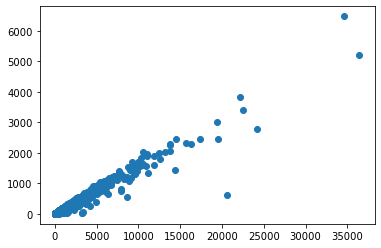

In [81]:
plt.scatter(posts['status_length'], posts['word_count']);

105.71047639999999


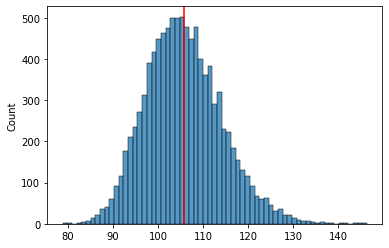

In [82]:
sample_means = []
for i in range(10000):
    s = np.random.choice(posts['word_count'], size = 500, replace = False) 
    x_bar = s.mean()
    sample_means.append(x_bar)

sns.histplot(sample_means)
plt.axvline(np.mean(sample_means), color = 'r');
print(np.mean(sample_means))

- The above distribution is a random sampling from the word_count column. 
- We can observe an even distribution around the sample mean of 81 words. We should get rid of outliers ie rows that have word counts that exceed 3 standard deviations from the mean. 
- Below is a box plot of our distribution. As we can see, there is a lot of data that falls outside the 75% quartile. 


C:\Users\tsuts\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


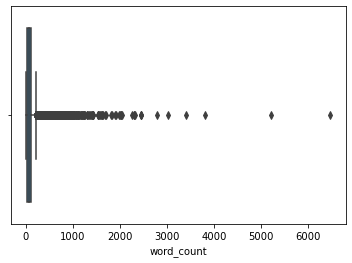

In [83]:
sns.boxplot(posts['word_count']);

- But before cleaning for outliers, let's also take a look at a distribution of status length. 

661.4169868


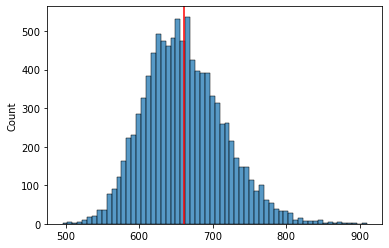

In [84]:
sample_means = []
for i in range(10000):
    s = np.random.choice(posts['status_length'], size = 500, replace = False) 
    x_bar = s.mean()
    sample_means.append(x_bar)

sns.histplot(sample_means)
plt.axvline(np.mean(sample_means), color = 'r');
print(np.mean(sample_means))

C:\Users\tsuts\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


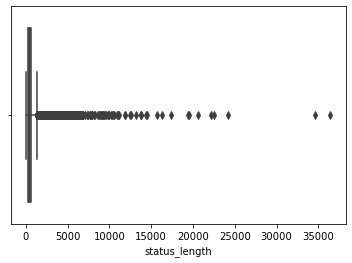

In [85]:
sns.boxplot(posts['status_length']);

### Now let's get rid of the data that fall more than 3 standard deviations away. 


In [86]:
#posts.reset_index(inplace=True)

In [87]:
posts.head()

,index,selftext,title,subreddit,text,status_length,word_count
0,1,\nhttps://www.coindesk.com/16-ethereum-predict...,16 Ethereum Predictions From a Crypto Oracle,1,\nhttpswwwcoindeskcom16ethereumpredictionscryp...,97,7
1,8,Alright so I’ve been on the ETH train for some...,Upside of Ether?,1,alright so ive been on the eth train for some ...,705,142
2,15,i tried almost a year and a half ago to get in...,i need help,1,i tried almost a year and a half ago to get in...,816,156
3,16,"Hi guys, I am not very familiar with ethereum ...",New to this... is now a good time to invest in...,1,hi guys i am not very familiar with ethereum b...,390,76
4,21,"Hi everyone, I think this is the most suited s...",Should I stake?,1,hi everyone i think this is the most suited su...,662,129


In [88]:
# z-scores
z = np.abs(stats.zscore(posts['word_count']))
print(z)

[0.51284354 0.18854494 0.26128153 ... 0.21670173 0.1699425  0.24049965]


In [89]:
# create list of z_scores whose values are greater than 3
outliers = [] 
outliers.append(np.where(z>3))
outliers

[(array([  263,   304,   305,   529,   584,   629,   666,   734,   834,
           861,   867,   873,   878,   886,   887,   941,   945,   963,
          1010,  1076,  1229,  1423,  1485,  1587,  1619,  1634,  1740,
          1742,  1800,  2052,  2064,  2103,  2131,  2177,  2278,  2310,
          2325,  2330,  2372,  2374,  2430,  2465,  2471,  2483,  2488,
          2529,  2534,  2645,  2665,  2671,  2698,  2712,  2719,  2745,
          2748,  2756,  2757,  2768,  2787,  2833,  2855,  2876,  2893,
          2899,  2999,  3055,  3060,  3176,  3227,  3284,  3338,  3368,
          3373,  3383,  3426,  3433,  3444,  3464,  3602,  3605,  3621,
          3656,  3804,  3811,  3843,  3869,  3905,  3927,  3946,  3997,
          4000,  4003,  4060,  4066,  4069,  4084,  4105,  4107,  4122,
          4129,  4135,  4148,  4155,  4170,  4202,  4206,  4208,  4268,
          4303,  4362,  4378,  4423,  4444,  4488,  4507,  4572,  4579,
          4580,  4582,  4589,  4617,  4620,  4640,  4643,  4721,

In [90]:
# how many 'word_count' outliers
range(len(outliers[0][0])) 

range(0, 175)

In [91]:
# example outliers
posts['word_count'][263]

926

In [92]:
# create list of all outlier values for word_count
outliers_list = []
for index in (outliers[0][0]):
    #print(index)
    outliers_list.append(posts['word_count'][index])
outliers_list[0:10]

[926, 825, 825, 1204, 724, 1902, 1267, 2046, 2439, 3406]

- we want to get rid of all the values from this list 

In [93]:
# filter for outliers for word count because we want to take words out first 

posts = posts[(np.abs(stats.zscore(posts['word_count'])) < 3)]
posts = posts[(np.abs(stats.zscore(posts['status_length'])) < 3)]


C:\Users\tsuts\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


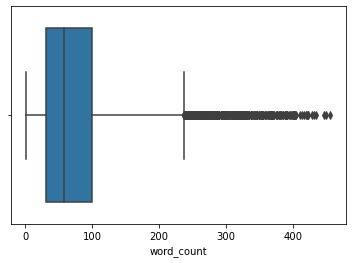

In [94]:
sns.boxplot(posts['word_count'], whis=1.9946);

C:\Users\tsuts\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


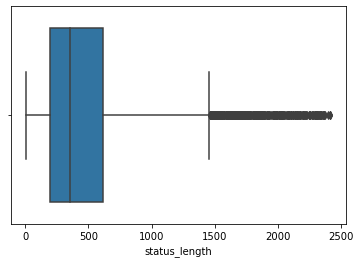

In [95]:
sns.boxplot(posts['status_length'], whis=1.9946);

- Box plots look much better. 

In [96]:
posts.shape

(10213, 7)

In [97]:
posts.to_csv('./datasets/posts.csv')

- we got ride of over 600 outliers

- These subreddits have a lot of integers. It's the nature of finance. Some of them are useful Ethereum addresses, most of which are denoted by the first two characters being '0x'. I want to take out all the integers from the trainset because I don't think numbers will help the model predict whether the text is from a Bitcoin or an Ethereum subreddit. However, I want to keep the ETH addresses because this will most likely improve the model's predictions for Ethereum subreddits.

- Using RegEx I will find all of the texts that begin with '0x' and all of the texts that are integers 




- I want to lemmatize my text data so that my model doesn't learn from redundancies. For example, instead of the model learning 'happy', 'happiness', and 'happily,' I want to create a base word, in this case 'happy,' for these three because they have similar meanings. Therefore the model will only learn from happy. 
- Below is code to briefly demonstrate how lemmatizing the data will yield fewer text words for when I CountVectorize my data. It is not important to the model. 


In [98]:
posts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10213 entries, 0 to 10631
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          10213 non-null  int64 
 1   selftext       10213 non-null  object
 2   title          10213 non-null  object
 3   subreddit      10213 non-null  int64 
 4   text           10213 non-null  object
 5   status_length  10213 non-null  int64 
 6   word_count     10213 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 638.3+ KB


# Token Experimentation: RegEx

- code in this section is an exploration of tokenized data 
- it will not be used in the model 
- instead I will call the Lemmatizer in my CountVectorizer when I create my model 

In [99]:
# Instantiate Regex
tokenizer = RegexpTokenizer(r'\w+') 

In [100]:
posts_tokens = []
for i in posts['text']: 
    posts_tokens.append(tokenizer.tokenize(i))
posts_tokens[1]

['alright',
 'so',
 'ive',
 'been',
 'on',
 'the',
 'eth',
 'train',
 'for',
 'some',
 'time',
 'now',
 'sold',
 'on',
 'the',
 'concept',
 'and',
 'think',
 'the',
 'future',
 'is',
 'very',
 'bright',
 'what',
 'i',
 'dont',
 'know',
 'is',
 'there',
 'any',
 'sort',
 'of',
 'realistic',
 'way',
 'to',
 'arrive',
 'at',
 'a',
 'best',
 'case',
 'scenario',
 'price',
 'valuation',
 'for',
 'eth',
 'for',
 'example',
 'if',
 'btc',
 'can',
 'gain',
 'equal',
 'footing',
 'with',
 'gold',
 'from',
 'a',
 'market',
 'cap',
 'perspective',
 'we',
 'could',
 'roughly',
 'expect',
 'a',
 '500k',
 'btc',
 'sure',
 'there',
 'is',
 'plenty',
 'of',
 'variance',
 'up',
 'or',
 'down',
 'based',
 'on',
 'a',
 'variety',
 'pack',
 'of',
 'factors',
 'but',
 'i',
 'can',
 'get',
 'a',
 'rough',
 'idea',
 'of',
 'what',
 'it',
 'could',
 'be',
 'worth',
 'is',
 'there',
 'anything',
 'we',
 'can',
 'look',
 'at',
 'to',
 'estimate',
 'the',
 'best',
 'case',
 'price',
 'scenario',
 'for',
 'eth',


In [101]:
print(posts_tokens[1])

['alright', 'so', 'ive', 'been', 'on', 'the', 'eth', 'train', 'for', 'some', 'time', 'now', 'sold', 'on', 'the', 'concept', 'and', 'think', 'the', 'future', 'is', 'very', 'bright', 'what', 'i', 'dont', 'know', 'is', 'there', 'any', 'sort', 'of', 'realistic', 'way', 'to', 'arrive', 'at', 'a', 'best', 'case', 'scenario', 'price', 'valuation', 'for', 'eth', 'for', 'example', 'if', 'btc', 'can', 'gain', 'equal', 'footing', 'with', 'gold', 'from', 'a', 'market', 'cap', 'perspective', 'we', 'could', 'roughly', 'expect', 'a', '500k', 'btc', 'sure', 'there', 'is', 'plenty', 'of', 'variance', 'up', 'or', 'down', 'based', 'on', 'a', 'variety', 'pack', 'of', 'factors', 'but', 'i', 'can', 'get', 'a', 'rough', 'idea', 'of', 'what', 'it', 'could', 'be', 'worth', 'is', 'there', 'anything', 'we', 'can', 'look', 'at', 'to', 'estimate', 'the', 'best', 'case', 'price', 'scenario', 'for', 'eth', 'are', 'you', 'all', 'in', 'the', 'same', 'boat', 'as', 'me', 'where', 'i', 'believe', 'in', 'ethereum', 'and',

In [102]:
# Instantiate lemmatizer.
lemmatizer = WordNetLemmatizer()

In [103]:
lem_text_tokens = [lemmatizer.lemmatize(i) for i in posts_tokens[12]]
lem_text_tokens[0:5]

['im', 'newer', 'to', 'crypto', 'and']

In [104]:
token_lem = []
tokens = []
for i in range(len(posts_tokens)):
    for j in posts_tokens[i]: 
        tokens.append(j)
        token_lem.append(lemmatizer.lemmatize(j))
token_lem[0:5]

['httpswwwcoindeskcom16ethereumpredictionscryptooracle16',
 'ethereum',
 'prediction',
 'from',
 'a']

In [105]:
list(zip(tokens, token_lem))[0:5]


[('httpswwwcoindeskcom16ethereumpredictionscryptooracle16',
  'httpswwwcoindeskcom16ethereumpredictionscryptooracle16'),
 ('ethereum', 'ethereum'),
 ('predictions', 'prediction'),
 ('from', 'from'),
 ('a', 'a')]

- Above we can see the difference between the lemma and the text data. Not all the words are different, but some of them are which reduces the amount of different variations the same meaning can be represented in text. it might be worth examining differences in model performance given lemma and stems. 

I've cleaned the data of all upper case letters, special characters, and outliers. 

Now I want to check out most frequent words to create a short stop words list. 

### Looking for stop words 

In [106]:
# Instantiate a CountVectorizer with stopwords = 'TPDNM'
# used from sklearn documentation https://scikit-learn.org/stable/modules/feature_extraction.html
# it allows me to call LemmaTokenizer() with my Pipeline()
class LemmaTokenizer:
    def __init__(self):
         self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
         # return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t not in stopwords.words('english')]
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]


#cvec = CountVectorizer(tokenizer=LemmaTokenizer(), stop_words='english')

- Before I model my data, I want to CountVectorize my texts to see the most common words in the data. They might be too telling of which subreddit post the text came from and should be included in my stop_words list when I instantiate my transformers. 


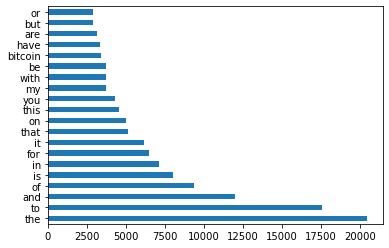

In [107]:
X = posts['text']
y = posts['subreddit']

# Split the data into the training and testing sets for a prelim CountVectorizer
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

cvec = CountVectorizer()
cvec.fit(X_train)
X_train = cvec.transform(X_train)
X_train_df = pd.DataFrame(X_train.todense(), 
                          columns=cvec.get_feature_names())
X_train_df.sum().sort_values(ascending=False).head(20).plot(kind='barh');

- Most of the most common words seem like they will be included in the english stop words list. However, words like 'bitcoin' and 'ethereum' might be too much of a giveaway for predicting which subreddit a test came from. I will also include 'btc' and 'eth' which are abbreviations for bitcoin and ethereum since they are also commonly used for both assets. 

In [108]:
# add stop words to english stop words list

my_additional_stop_words = ['btc', 'eth', 'ethereum', 'bitcoin' ]
my_stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

# source: https://stackoverflow.com/questions/24386489/adding-words-to-scikit-learns-countvectorizers-stop-list/24386751

### Create a sentiment column

In [111]:
sia = SentimentIntensityAnalyzer()
def get_compound_sentiment(post):
    return sia.polarity_scores(post)['compound']

In [112]:
posts['sentiment'] = posts['text'].apply(get_compound_sentiment)

In [113]:
posts.head(10)

,index,selftext,title,subreddit,text,status_length,word_count,sentiment
0,1,\nhttps://www.coindesk.com/16-ethereum-predict...,16 Ethereum Predictions From a Crypto Oracle,1,\nhttpswwwcoindeskcom16ethereumpredictionscryp...,97,7,0.0000
1,8,Alright so I’ve been on the ETH train for some...,Upside of Ether?,1,alright so ive been on the eth train for some ...,705,142,0.9724
2,15,i tried almost a year and a half ago to get in...,i need help,1,i tried almost a year and a half ago to get in...,816,156,0.9355
3,16,"Hi guys, I am not very familiar with ethereum ...",New to this... is now a good time to invest in...,1,hi guys i am not very familiar with ethereum b...,390,76,0.9109
4,21,"Hi everyone, I think this is the most suited s...",Should I stake?,1,hi everyone i think this is the most suited su...,662,129,0.9294
5,23,Spoiler alert.. a lot. \nWe go frontrun on tr...,We took a tour around the dark forest to see h...,1,spoiler alert a lot \nwe go frontrun on trans...,396,46,0.7269
6,24,So The Secret Network Ethereum bridge is live....,More secretEther users needed! Privacy fans un...,1,so the secret network ethereum bridge is live ...,874,124,0.9801
7,29,Hi ethereum holders/investors/stakers etc.\n\n...,Max supply of ETH,1,hi ethereum holdersinvestorsstakers etc\n\nis ...,142,27,0.1280
8,33,\nIf you’ve been keeping up with Ripple then y...,XRP right now lol,1,\nif youve been keeping up with ripple then yo...,272,42,0.8909
9,35,I know the basics of crypto but I’m not the mo...,Is this a bubble?,1,i know the basics of crypto but im not the mos...,539,105,0.7301


In [114]:
posts.to_csv('./datasets/posts.csv')

### Baseline Model
 - what is our baseline model? 

In [115]:
y.value_counts(normalize=True)

1    0.531871
0    0.468129
Name: subreddit, dtype: float64

- 53% of the time, we can expect a subreddit from the data to be from the Bitcoin subreddit. This is our baseline case. 

## Models 

### CountVectorizer/TfidVectorizer in RandomForest/AdaBoost/Bagging Classifiers

- In this section, I'm going to model my text using CountVectorizer/TfidVectorizer transformers in RandomForest/AdaBoost/BaggingClassifier models. 
- Within the CountVectorizer, I'm using a LemmaTokenizer to simplify some of the text data.  
- For the purpose of my problem state, I'm going to use a feature union within my pipelines and run a gridsearch on all models. 
- By the end I will pick the best model and fine tune the hyperparameters for optimal performance. 



In [1051]:
posts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9805 entries, 0 to 10631
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          9805 non-null   int64  
 1   selftext       9805 non-null   object 
 2   title          9805 non-null   object 
 3   subreddit      9805 non-null   int64  
 4   text           9805 non-null   object 
 5   status_length  9805 non-null   int64  
 6   word_count     9805 non-null   int64  
 7   sentiment      9805 non-null   float64
dtypes: float64(1), int64(4), object(3)
memory usage: 689.4+ KB


In [1053]:
y.value_counts(normalize=True) # baseline model 

0    0.524426
1    0.475574
Name: subreddit, dtype: float64

In [902]:
# with sentiment 

get_text_data = FunctionTransformer(lambda x: x['text'], validate = False)
get_numeric_data = FunctionTransformer(lambda x: x[['sentiment']], validate = False)

X = posts[['text', 'sentiment']]
y = posts['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

cvec_pipe1 = Pipeline([
    ('features', FeatureUnion([
        ('numeric_features', Pipeline([
           ('selector', get_numeric_data), 
            ('ss', StandardScaler())
        ])),
        ('text_features', Pipeline([
        ('selector', get_text_data), 
        ('cvec', CountVectorizer(tokenizer=LemmaTokenizer(), stop_words=my_stop_words))
        ])),  
    ])),
    ('rf', RandomForestClassifier())
])

cvec_pipe2 = Pipeline([
    ('features', FeatureUnion([
        ('numeric_features', Pipeline([
           ('selector', get_numeric_data), 
            ('ss', StandardScaler())
        ])),
        ('text_features', Pipeline([
        ('selector', get_text_data), 
        ('cvec', CountVectorizer(tokenizer=LemmaTokenizer(), stop_words=my_stop_words))
        ])), 
    ])),
    ('ada', AdaBoostClassifier())
])

cvec_pipe3 = Pipeline([
    ('features', FeatureUnion([
        ('numeric_features', Pipeline([
           ('selector', get_numeric_data), 
            ('ss', StandardScaler())
        ])),
        ('text_features', Pipeline([
        ('selector', get_text_data), 
        ('cvec', CountVectorizer(tokenizer=LemmaTokenizer(), stop_words=my_stop_words))
        ])), 
    ])),
    ('bag', BaggingClassifier())
])

tvec_pipe1 = Pipeline([
    ('features', FeatureUnion([
        ('numeric_features', Pipeline([
           ('selector', get_numeric_data), 
            ('ss', StandardScaler())
        ])),
        ('text_features', Pipeline([
        ('selector', get_text_data), 
        ('tvec', TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words=my_stop_words))
        ])), 
    ])),
    ('rf', RandomForestClassifier())
])

tvec_pipe2 = Pipeline([
    ('features', FeatureUnion([
        ('numeric_features', Pipeline([
           ('selector', get_numeric_data), 
            ('ss', StandardScaler())
        ])),
        ('text_features', Pipeline([
        ('selector', get_text_data), 
        ('tvec', TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words=my_stop_words))
        ])), 
    ])),
    ('ada', AdaBoostClassifier())
])


tvec_pipe3 = Pipeline([
    ('features', FeatureUnion([
        ('numeric_features', Pipeline([
           ('selector', get_numeric_data), 
            ('ss', StandardScaler())
        ])),
        ('text_features', Pipeline([
        ('selector', get_text_data), 
        ('tvec', TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words=my_stop_words))
        ])), 
    ])),
    ('bag', BaggingClassifier())
])

cvec_pipe_params = {
    'features__text_features__cvec__max_features': [5_000, 6000, 7000],
    'features__text_features__cvec__min_df': [2, 3],
    'features__text_features__cvec__max_df': [.5, .7, .9],
    'features__text_features__cvec__ngram_range': [(1,1)]
}
tvec_pipe_params = {
    'features__text_features__tvec__max_features': [5_000, 6000, 7000],
    'features__text_features__tvec__min_df': [2, 3],
    'features__text_features__tvec__max_df': [.5, .7, .9],
    'features__text_features__tvec__ngram_range': [(1,1)]
}

cvec_pipes = [cvec_pipe1, cvec_pipe2, cvec_pipe3]
cvec_grids = []
for pipe in cvec_pipes: 
    gs = GridSearchCV(pipe, 
                      param_grid=cvec_pipe_params,
                      cv=5, 
                      verbose=2,
                      ) # 5-fold cross-validation.
    cvec_grids.append(gs)

    
    
    
tvec_pipes = [tvec_pipe1, tvec_pipe2, tvec_pipe3]
tvec_grids = []
for pipe in tvec_pipes: 
    gs = GridSearchCV(pipe,
                      param_grid=tvec_pipe_params, 
                      cv=5, 
                      verbose=2,
                      ) # 5-fold cross-validation.
    tvec_grids.append(gs)
    



t0 = time.time()

best_cvec_scores = []
best_cvec_train_scores = []
best_cvec_test_scores = []
best_cvec_params = []

for grid in cvec_grids: 

    #print(grid)
    grid.fit(X_train, y_train)
    print(f'Best Score: {grid.best_score_} Train Set Score: {grid.score(X_train, y_train)} Test Set Score: {grid.score(X_test, y_test)} Best Parameters: {grid.best_params_}')
    best_cvec_scores.append(grid.best_score_)
    best_cvec_train_scores.append(grid.score(X_train, y_train))
    best_cvec_test_scores.append(grid.score(X_test, y_test))
    best_cvec_params.append(grid.best_params_)

best_tvec_scores = []
best_tvec_train_scores = []
best_tvec_test_scores = []
best_tvec_params = []   

for grid in tvec_grids: 

    #print(grid)
    grid.fit(X_train, y_train)
    print(f'Best Score: {grid.best_score_} Train Set Score: {grid.score(X_train, y_train)} Test Set Score {grid.score(X_test, y_test)} Best Parameters: {grid.best_params_}')
    
    best_tvec_scores.append(grid.best_score_)
    best_tvec_train_scores.append(grid.score(X_train, y_train))
    best_tvec_test_scores.append(grid.score(X_test, y_test))
    best_tvec_params.append(grid.best_params_)
    
    print(f' This cell took {time.time() - t0} seconds to run')


print(f'Best cvec scores: {best_cvec_scores}')

In [919]:
print(f'Best tvec scores : {best_tvec_scores}')

Best tvec scores : [0.8392476128540146, 0.7801827179556733, 0.7970786225092479]


In [920]:
print(f'Best cvec train scores: {best_cvec_train_scores}')
print(f'Best cvec test scores : {best_cvec_test_scores}')

Best cvec train scores: [0.9986299284518192, 0.7954026488049931, 0.9879738164104126]
Best cvec test scores : [0.8389987639060569, 0.792027194066749, 0.8062422744128553]


In [1056]:
print(f'Best tvec train scores: {best_tvec_train_scores}')
print(f'Best tvec test scores: {best_tvec_test_scores}')

Best tvec train scores: [0.9986299284518192, 0.7970771806972142, 0.9891916577865733]
Best tvec test scores: [0.8411619283065513, 0.7877008652657602, 0.804079110012361]


In [1101]:
# without sentiment 
X = posts['text']
y = posts['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

pipe = Pipeline([
    ('tvec', TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words=my_stop_words)), 
    ('nb', MultinomialNB())
])

pipe_params = {
    'tvec__max_features': [6000,7000, 8000],
    'tvec__min_df': [2, .01, .02],
    'tvec__max_df': [.2],
    'tvec__ngram_range': [(1,1), (1,2)]
}


gs = GridSearchCV(pipe, # what object are we optimizing?
                      param_grid=pipe_params, # what parameters values are we searching?
                      cv=10, 
                      verbose=2,
                      ) # 5-fold cross-validation.
t0 = time.time()

gs.fit(X, y)
print(f'Best Score: {gs.best_score_} Train Set Score: {gs.score(X_train, y_train)} Test Set Score: {gs.score(X_test, y_test)} Best Parameters: {gs.best_params_}')

print(f' This cell took {time.time() - t0} seconds to run')


Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 1), total=   4.8s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 1), total=   4.8s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 1), total=   4.8s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 1), total=   4.9s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 1), total=   4.8s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 1), total=   4.8s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 1), total=   4.7s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 1), total=   4.9s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 1), total=   4.7s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 1), total=   4.9s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2), total=   5.7s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2), total=   5.8s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2), total=   5.7s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2), total=   5.8s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2), total=   5.6s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2), total=   5.7s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2), total=   5.7s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2), total=   5.7s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2), total=   5.7s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2), total=   5.7s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 1), total=   4.9s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 1), total=   4.8s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 1), total=   4.8s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 1), total=   4.8s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 1), total=   4.9s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 1), total=   4.8s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 1), total=   4.8s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 1), total=   4.8s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 1), total=   5.0s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 1), total=   4.8s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 2), total=   5.8s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 2), total=   5.8s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 2), total=   5.8s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 2), total=   5.9s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 2), total=   6.1s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 2), total=   6.1s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 2), total=   5.7s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 2), total=   5.9s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 2), total=   5.8s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.01, tvec__ngram_range=(1, 2), total=   5.9s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 1), total=   4.9s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 1), total=   4.9s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 1), total=   4.9s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 1), total=   4.9s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 1), total=   4.9s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 1), total=   4.8s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 1), total=   4.8s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 1), total=   4.8s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 1), total=   4.9s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 1), total=   4.8s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 2), total=   5.9s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 2), total=   6.0s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 2), total=   6.0s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 2), total=   5.9s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 2), total=   5.8s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 2), total=   5.8s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 2), total=   5.9s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 2), total=   5.7s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 2), total=   5.8s
[CV] tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=6000, tvec__min_df=0.02, tvec__ngram_range=(1, 2), total=   5.8s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 1), total=   4.8s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 1), total=   5.0s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 1), total=   4.8s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 1), total=   4.9s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 1), total=   4.9s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 1), total=   4.9s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 1), total=   4.9s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 1), total=   4.9s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 1), total=   4.7s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 1), total=   4.9s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2), total=   5.7s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2), total=   5.6s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2), total=   5.8s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2), total=   5.9s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2), total=   5.7s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2), total=   5.9s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2), total=   5.9s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2), total=   5.7s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2), total=   5.7s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2), total=   5.7s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 1), total=   4.9s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 1), total=   4.8s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 1), total=   4.9s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 1), total=   4.9s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 1), total=   4.8s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 1), total=   4.8s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 1), total=   4.8s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 1), total=   4.9s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 1), total=   4.9s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 1), total=   4.7s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 2), total=   5.7s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 2), total=   5.9s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 2), total=   6.0s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 2), total=   5.7s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 2), total=   5.7s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 2), total=   6.0s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 2), total=   5.8s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 2), total=   6.0s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 2), total=   5.8s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.01, tvec__ngram_range=(1, 2), total=   5.8s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 1), total=   4.8s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 1), total=   4.8s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 1), total=   4.9s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 1), total=   4.8s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 1), total=   5.0s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 1), total=   5.2s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 1), total=   4.9s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 1), total=   4.9s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 1), total=   4.9s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 1), total=   5.1s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 2), total=   6.0s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 2), total=   5.8s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 2), total=   6.0s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 2), total=   6.1s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 2), total=   6.1s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 2), total=   6.0s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 2), total=   5.8s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 2), total=   5.9s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 2), total=   5.8s
[CV] tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=7000, tvec__min_df=0.02, tvec__ngram_range=(1, 2), total=   6.2s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 1), total=   5.0s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 1), total=   5.3s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 1), total=   5.2s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 1), total=   5.0s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 1), total=   4.9s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 1), total=   5.0s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 1), total=   5.1s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 1), total=   5.0s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 1), total=   5.0s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 1), total=   5.0s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 2), total=   6.3s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 2), total=   6.2s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 2), total=   6.2s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 2), total=   6.1s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 2), total=   5.9s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 2), total=   5.8s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 2), total=   6.0s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 2), total=   5.9s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 2), total=   5.9s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=2, tvec__ngram_range=(1, 2), total=   5.9s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 1), total=   5.0s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 1), total=   5.0s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 1), total=   4.9s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 1), total=   5.0s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 1), total=   5.0s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 1), total=   4.9s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 1), total=   4.8s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 1), total=   4.9s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 1), total=   5.0s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 1), total=   4.8s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 2), total=   5.8s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 2), total=   5.8s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 2), total=   5.9s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 2), total=   6.0s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 2), total=   5.9s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 2), total=   5.9s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 2), total=   5.8s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 2), total=   5.9s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 2), total=   6.0s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.01, tvec__ngram_range=(1, 2), total=   5.8s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 1), total=   5.0s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 1), total=   4.9s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 1), total=   4.8s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 1), total=   4.7s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 1), total=   4.8s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 1), total=   4.9s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 1), total=   5.0s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 1), total=   5.1s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 1), total=   4.8s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 1) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 1), total=   4.8s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 2), total=   5.8s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 2), total=   5.8s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 2), total=   5.8s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 2), total=   5.7s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 2), total=   5.7s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 2), total=   5.7s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 2), total=   5.6s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 2), total=   5.6s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 2), total=   5.7s
[CV] tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 2) 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  tvec__max_df=0.2, tvec__max_features=8000, tvec__min_df=0.02, tvec__ngram_range=(1, 2), total=   5.8s


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 16.1min finished
C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Best Score: 0.8677193201439597 Train Set Score: 0.9036383011112803 Test Set Score: 0.9032756489493201 Best Parameters: {'tvec__max_df': 0.2, 'tvec__max_features': 7000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}
 This cell took 978.1077628135681 seconds to run


- The best model from the GridSearch is the RandomForest model using a CountVectorizer.

- In the next notebook, I'm going to tune my hyperparamaters on my best models and determine my best model. 
- From there, I will interpret the results and see what we can learn from r/Bitcoin and r/Ethereum. 